# Set-up Environment

In [1]:
spark.version

'3.1.3'

In [2]:
import os
import pandas as pd
import numpy as np

from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
warnings.filterwarnings(action = 'ignore')

In [3]:
!pip3 install nltk -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.3/772.3 kB 60.6 MB/s eta 0:00:00
  Attempting uninstall: regex
    Found existing installation: regex 2021.4.4
    Uninstalling regex-2021.4.4:
      Successfully uninstalled regex-2021.4.4
  Attempting uninstall: nltk
    Found existing installation: nltk 3.6.4
    Uninstalling nltk-3.6.4:
      Successfully uninstalled nltk-3.6.4


In [4]:
import re
import json
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer, IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
from google.cloud import storage

spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)

## Set-up COS functions for GCP

In [6]:
# List all files in given COS directory
def list_blobs_pd(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix = folder_name))

    blob_name = []
    blob_size = []
    
    for blob in blobs:
        blob_name.append(blob.name)
        blob_size.append(blob.size)

    blobs_df = pd.DataFrame(list(zip(blob_name, blob_size)), columns = ['Name','Size'])

    #blobs_df = blobs_df.style.format({"Size": "{:,.0f}"}) 
    
    return blobs_df

In [7]:
# Delete folder from COS bucket
def delete_folder(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix = folder_name))

    for blob in blobs:
        blob.delete()

In [8]:
# Reading data from bucket
bucket = 'shijia-bdp-class'

# Read Filtered Data Parquet Files

In [9]:
blob_list = list_blobs_pd(bucket, 'inter_result/filtered')

In [10]:
blob_list.head(10)

,Name,Size
0,inter_result/filtered/,0
1,inter_result/filtered/_SUCCESS,0
2,inter_result/filtered/part-00000-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,79905281
3,inter_result/filtered/part-00001-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,79675239
4,inter_result/filtered/part-00002-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,79120751
5,inter_result/filtered/part-00003-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,78856771
6,inter_result/filtered/part-00004-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,78841226
7,inter_result/filtered/part-00005-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,78763533
8,inter_result/filtered/part-00006-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,78783569
9,inter_result/filtered/part-00007-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,78734456


In [11]:
path = 'gs://shijia-bdp-class/inter_result/filtered'
tweets_filtered = spark.read.parquet(path)

In [12]:
tweets_filtered.printSchema()

root
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- created_at: string (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- favourites_count: long (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- friends_count: long (nullable = true)
 |    |-- geo_enabled: boolean (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- listed_count: long (nullable = true)
 |    |-- location: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- protected: boolean (nullable = true)
 |    |-- screen_name: string (nullable = true)
 |    |-- statuses_count: long (nullable = true)
 |    |-- verified: boolean (nullable = true)
 |-- quote_c

In [13]:
tweets_filtered.count()

71341087

In [14]:
tweets_filtered.limit(10).toPandas()

,coordinates,created_at,id,text,user,quote_count,reply_count,favorite_count,retweet_count,retweeted,retweeted_from,retweeted_status,cleaned_text,tokened_text,filtered_tokens
0,None,Tue Aug 23 09:04:40 +0000 2022,1562002872362889216,Join the Loma Linda University Health team! See our latest job opening here: https://t.co/t9dH1AL8Le #LomaLinda #HealthCareers,"(Tue Jun 12 18:48:55 +0000 2012, Welcome to LLUH– home to some of the nation’s largest clinical programs, providing Care for more than 33,000 inpatients and .5 million outpatients annually., 0, 867, 120, False, 606543491, 249, Loma Linda, California, Loma Linda Careers, False, LLU_Careers, 1695, False)",0,0,0,0,,None,None,join the loma linda university health team see our latest job opening here,"[join, the, loma, linda, university, health, team, see, our, latest, job, opening, here]","[join, loma, linda, university, health, team, see, latest, job, opening]"
1,None,Tue Aug 23 09:04:41 +0000 2022,1562002876620148737,RT @TansuYegen: Her dog is waiting for her to come back from the school and grabs the backpack to home…\n\n https://t.co/ut4DLSSAZq,"(Sat May 01 09:52:42 +0000 2021, influencer, 12192, 28, 406, False, 1388431106991554564, 0, None, Bala valvi, False, ValviBala, 10778, False)",0,0,0,0,RT,TansuYegen,"(None, Mon Aug 22 06:57:20 +0000 2022, 80676, 1561608443638734849, 518, 433, 9088, False, Her dog is waiting for her to come back from the school and grabs the backpack to home…\n\n https://t.co/ut4DLSSAZq, (Fri Dec 04 11:56:23 +0000 2009, 'Personal account' Follow me for videos and news #technology #metaverse #RPA #artificialIntelligence #viral #funny Author of the business book ‘Shine’, 6716, 875897, 882, True, 94543804, 3906, WorldWide, Tansu YEĞEN, False, TansuYegen, 30511, True))",her dog is waiting for her to come back from the school and grabs the backpack to home,"[her, dog, is, waiting, for, her, to, come, back, from, the, school, and, grabs, the, backpack, to, home]","[dog, waiting, come, back, school, grabs, backpack, home]"
2,None,Tue Aug 23 09:04:41 +0000 2022,1562002877219885056,"RT @trev_mackenzie: Someone recently asked me one thing I look for when I visit schools, walk through halls, and watch teachers do what the…","(Sat Jul 13 14:20:06 +0000 2013, Innovator, Strategic Thinker, Learner, 12406, 2480, 2029, True, 1591118918, 71, Whadjuk Noongar / Perth, WA, Adam Brooks, False, brookssensei, 9613, False)",0,0,0,0,RT,trev_mackenzie,"(None, Tue Aug 23 03:21:40 +0000 2022, 7, 1561916556182839296, 2, 0, 3, False, Someone recently asked me one thing I look for when I visit schools, walk through halls, and watch teachers do what… https://t.co/Hna7I8Vacx, (Wed Mar 06 04:45:36 +0000 2013, Educator (in #sd61learn), author, speaker, inquirer. Bringing wonderment & curiosity back to schools around the 🌎. Author of #DiveintoInquiry & #InquiryMindset, 60228, 22778, 4471, True, 1245281827, 310, Victoria, BC, Canada, Trevor MacKenzie, False, trev_mackenzie, 52092, False))",someone recently asked me one thing i look for when i visit schools walk through halls and watch teachers do what the,"[someone, recently, asked, me, one, thing, i, look, for, when, i, visit, schools, walk, through, halls, and, watch, teachers, do, what, the]","[someone, recently, asked, one, thing, look, visit, schools, walk, halls, watch, teachers]"
3,None,Tue Aug 23 09:04:41 +0000 2022,1562002877631156224,"RT @Tea_witdre: I done graduated high school, went to college, graduated college, started my career, went through two recessions, 3 global…","(Wed Feb 10 22:06:29 +0000 2010, IG: jasalesia_ SC: jasalesia12, 4228, 270, 516, False, 113156281, 1, United States, 🤸🏽‍♀️🤸🏽‍♀️Jas🤸🏽‍♀️, False, Alesia_In_Love, 31702, False)",0,0,0,0,RT,Tea_witdre,"(None, Mon Aug 22 15:35:17 +0000 2022, 29465, 1561738787482370050, 954, 362, 4990, False, I done graduated high school, went to college, graduated college, started my career, went through two recessions, 3… https://t.co/b8OUdtfXuj, (Wed Jun 29 05:06:54 +0000 2016

In [15]:
tweeterers_filtered = tweets_filtered.select('user.*')
tweeterers_filtered.limit(10).toPandas()

,created_at,description,favourites_count,followers_count,friends_count,geo_enabled,id,listed_count,location,name,protected,screen_name,statuses_count,verified
0,Tue Jun 12 18:48:55 +0000 2012,"Welcome to LLUH– home to some of the nation’s largest clinical programs, providing Care for more than 33,000 inpatients and .5 million outpatients annually.",0,867,120,False,606543491,249,"Loma Linda, California",Loma Linda Careers,False,LLU_Careers,1695,False
1,Sat May 01 09:52:42 +0000 2021,influencer,12192,28,406,False,1388431106991554564,0,None,Bala valvi,False,ValviBala,10778,False
2,Sat Jul 13 14:20:06 +0000 2013,"Innovator, Strategic Thinker, Learner",12406,2480,2029,True,1591118918,71,"Whadjuk Noongar / Perth, WA",Adam Brooks,False,brookssensei,9613,False
3,Wed Feb 10 22:06:29 +0000 2010,IG: jasalesia_ SC: jasalesia12,4228,270,516,False,113156281,1,United States,🤸🏽‍♀️🤸🏽‍♀️Jas🤸🏽‍♀️,False,Alesia_In_Love,31702,False
4,Sat Jun 04 07:04:10 +0000 2022,"Multifan mainly SKZ, Army, SVT, Enha, Treasure, NCT, Txt, Twice, Itzy, and more ❣",2745,354,882,False,1532981431869222912,0,Republic of the Philippines,foxI.Ny 🦊,False,agippanginnie,2646,False
5,Mon Dec 07 09:41:15 +0000 2009,Research,12934,1514,1609,False,95170708,0,Nigeria,Peter Ise,False,drisepeter,10768,False
6,Wed Jul 20 10:12:49 +0000 2016,None,1779,197,340,False,755707021995876352,0,None,nicole,False,nicxle_k,555,False
7,Tue Mar 01 18:11:36 +0000 2022,bad buddy enjoyer and 10 years ticket enthusiast,23435,594,186,True,1498722572334411778,3,she/her | 21,nini,False,goldenboypat,9548,False
8,Thu Aug 18 10:35:17 +0000 2022,Noor\nStudying for bba in USA lahore.\nStudent of Management sciences dept.,126,94,263,False,1560213658633998336,0,None,Noor,False,Noor23254504,922,False
9,Wed Dec 22 16:05:42 +0000 2010,Building. Creating. Learning.,7620,1320,1154,True,229513892,3,Lagos.,dami.,False,DamiYakubu,38595,False


In [16]:
retweets_filtered = tweets_filtered.select('retweeted_status.*').orderBy("retweet_count", ascending = False)
retweets_filtered.limit(10).toPandas()

,coordinates,created_at,favorite_count,id,quote_count,reply_count,retweet_count,retweeted,text,user
0,None,Tue Sep 07 20:02:35 +0000 2021,2037038,1435332689532440579,275296,31881,516954,False,So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,"(Tue Dec 01 20:29:52 +0000 2009, Nickelodeon's official Nick Jr. Twitter\nStream your favorite Nick Jr shows on @ParamountPlus, 928, 87485, 241, False, 93936628, 425, None, Nick Jr., False, nickjr, 5528, True)"
1,None,Tue Sep 07 20:02:35 +0000 2021,2037109,1435332689532440579,275298,31881,516951,False,So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,"(Tue Dec 01 20:29:52 +0000 2009, Nickelodeon's official Nick Jr. Twitter\nStream your favorite Nick Jr shows on @ParamountPlus, 928, 87487, 241, False, 93936628, 425, None, Nick Jr., False, nickjr, 5528, True)"
2,None,Tue Sep 07 20:02:35 +0000 2021,2037008,1435332689532440579,275297,31879,516928,False,So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,"(Tue Dec 01 20:29:52 +0000 2009, Nickelodeon's official Nick Jr. Twitter\nStream your favorite Nick Jr shows on @ParamountPlus, 928, 87480, 241, False, 93936628, 425, None, Nick Jr., False, nickjr, 5528, True)"
3,None,Tue Sep 07 20:02:35 +0000 2021,2036562,1435332689532440579,275299,31869,516795,False,So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,"(Tue Dec 01 20:29:52 +0000 2009, Nickelodeon's official Nick Jr. Twitter\nStream your favorite Nick Jr shows on @ParamountPlus, 929, 87469, 241, False, 93936628, 425, None, Nick Jr., False, nickjr, 5543, True)"
4,None,Tue Sep 07 20:02:35 +0000 2021,2036517,1435332689532440579,275296,31867,516772,False,So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,"(Tue Dec 01 20:29:52 +0000 2009, Nickelodeon's official Nick Jr. Twitter\nStream your favorite Nick Jr shows on @ParamountPlus, 929, 87469, 241, False, 93936628, 425, None, Nick Jr., False, nickjr, 5543, True)"
5,None,Tue Sep 07 20:02:35 +0000 2021,2036399,1435332689532440579,275298,31866,516743,False,So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,"(Tue Dec 01 20:29:52 +0000 2009, Nickelodeon's official Nick Jr. Twitter\nStream your favorite Nick Jr shows on @ParamountPlus, 929, 87476, 241, False, 93936628, 425, None, Nick Jr., False, nickjr, 5547, True)"
6,None,Tue Sep 07 20:02:35 +0000 2021,2036348,1435332689532440579,275290,31865,516711,False,So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,"(Tue Dec 01 20:29:52 +0000 2009, Nickelodeon's official Nick Jr. Twitter\nStream your favorite Nick Jr shows on @ParamountPlus, 929, 87480, 241, False, 93936628, 425, None, Nick Jr., False, nickjr, 5547, True)"
7,None,Tue Sep 07 20:02:35 +0000 2021,2036106,1435332689532440579,275298,31863,516614,False,So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,"(Tue Dec 01 20:29:52 +0000 2009, Nickelodeon's official Nick Jr. Twitter\nStream your favorite Nick Jr shows on @ParamountPlus, 929, 87485, 241, False, 93936628, 424, None, Nick Jr., False, nickjr, 5549, True)"
8,None,Tue Sep 07 20:02:35 +0000 2021,2036035,1435332689532440579,275298,31858,516596,False,So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,"(Tue Dec 01 20:29:52 +0000 2009, Nickelodeon's official Nick Jr. Twitter\nStream your favorite Nick Jr shows on @ParamountPlus, 929, 87498, 241, False, 93936628, 424, None, Nick Jr., False, nickjr, 5556, True)"
9,None,Tue Sep 07 20:02:35 +0000 2021,2036071,1435332689532440579,275298,31859,516593,False,So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,"(Tue Dec 01 20:29:52 +0000 2009, Nickelodeon's official Nick Jr. Twitter\nStream your favorite Nick Jr shows on @ParamountPlus, 929, 87501, 241, False, 93936628, 424, None, Nick Jr., False, nickjr, 5556, True)"


# Location Analysis

## Distribution of all Twitterers

In [17]:
import geopandas as gpd

In [18]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/miniconda3/share/proj failed


pop_est      continent                      name iso_a3  gdp_md_est  \
0     889953.0        Oceania                      Fiji    FJI        5496   
1   58005463.0         Africa                  Tanzania    TZA       63177   
2     603253.0         Africa                 W. Sahara    ESH         907   
3   37589262.0  North America                    Canada    CAN     1736425   
4  328239523.0  North America  United States of America    USA    21433226   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

<AxesSubplot:>

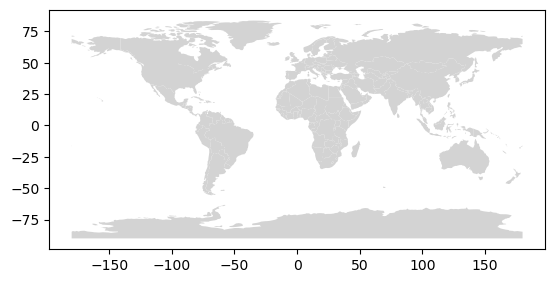

In [19]:
countries.plot(color="lightgrey")

In [20]:
geo_tweet = tweets_filtered.select('id', tweets_filtered.coordinates.coordinates[0].alias('longitude'),
                                   tweets_filtered.coordinates.coordinates[1].alias('latitude')).filter(tweets_filtered.coordinates.isNotNull())
geo_tweet.count()

90312

In [21]:
dist_tweet = geo_tweet.groupby('longitude', 'latitude').count()
p_dist_tweet = dist_tweet.orderBy('count').toPandas()
p_dist_tweet.head(20)

,longitude,latitude,count
0,-76.828798,40.293605,1
1,-6.683444,53.310917,1
2,-84.581230,34.038222,1
3,-80.376989,25.758185,1
4,-92.159066,46.748272,1
5,-83.137000,42.424000,1
6,-102.266005,40.987389,1
7,-75.572326,39.155299,1
8,-76.337592,42.217072,1
9,76.332328,32.246278,1


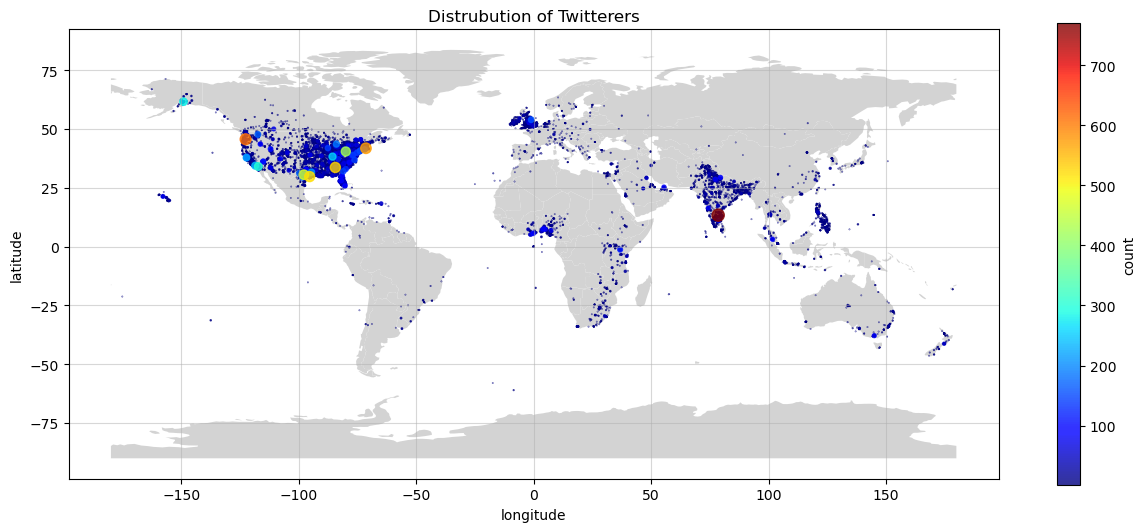

In [22]:
# initialize an axis
fig, ax = plt.subplots(figsize=(15,6))

# plot map on axis
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey",ax=ax)

# plot points
p_dist_tweet.plot(x = "longitude", y = "latitude", kind = "scatter", s = p_dist_tweet['count']/10,
                  c = "count", cmap = plt.get_cmap("jet"), alpha = 0.8,
                  title = "Distrubution of Twitterers", ax = ax, colorbar = True)

# add grid
ax.grid(b = True, alpha = 0.5)
plt.show()

## Distribution of Twitterers on Topic 'In-person Instruction'

In [23]:
topic = '|'.join(['person', 'instruction', 'remote', 'virtual', 'online'])

In [24]:
tweets_topic = tweets_filtered.withColumn('topic', when(col('cleaned_text').rlike(topic), 'related').otherwise('not-related'))
tweets_topic = tweets_topic.filter(tweets_topic.topic =='related')
tweets_topic.limit(5).toPandas()

,coordinates,created_at,id,text,user,quote_count,reply_count,favorite_count,retweet_count,retweeted,retweeted_from,retweeted_status,cleaned_text,tokened_text,filtered_tokens,topic
0,None,Tue Aug 23 09:05:05 +0000 2022,1562002977510113280,"RT @lisamariedavid: Scenes during the first day of in-person classes at a flooded school due to high tide, in Macabebe town, Pampanga provi…","(Fri Oct 27 22:20:07 +0000 2017, None, 184924, 211, 107, False, 924038023167307777, 0, Mt Holly, NJ, Ges T, False, Gesgal75, 117017, False)",0,0,0,0,RT,lisamariedavid,"(None, Mon Aug 22 10:48:39 +0000 2022, 16393, 1561666655209627648, 1718, 127, 4082, False, Scenes during the first day of in-person classes at a flooded school due to high tide, in Macabebe town, Pampanga p… https://t.co/8QIeoqx471, (Thu Dec 22 06:35:52 +0000 2011, Freelance photojournalist based in Manila, Philippines. Konrad-Adenauer Stiftung Fellow. lisamarie_david@yahoo.com, 11693, 1511, 2427, True, 443474545, 10, lisamariedavid.com, Lisa Marie David, False, lisamariedavid, 4687, False))",scenes during the first day of in person classes at a flooded school due to high tide in macabebe town pampanga provi,"[scenes, during, the, first, day, of, in, person, classes, at, a, flooded, school, due, to, high, tide, in, macabebe, town, pampanga, provi]","[scenes, first, day, person, classes, flooded, school, due, high, tide, macabebe, town, pampanga, provi]",related
1,None,Tue Aug 23 09:05:27 +0000 2022,1562003069671448577,RT @RexfordKingsley: NSS personnel chale if you wan date dier high school girls be your level oo,"(Wed Oct 31 18:41:48 +0000 2018, FC Barcelona👌 //Music 🎵, 461151, 12502, 2995, True, 1057704205731926017, 13, Ghana, 𝗔𝗻𝗱𝘆 𝗕𝗹𝗮𝗾 , False, Andy_blaq_, 285769, False)",0,0,0,0,RT,RexfordKingsley,"(None, Tue Aug 23 08:46:11 +0000 2022, 60, 1561998221760774145, 0, 4, 30, False, NSS personnel chale if you wan date dier high school girls be your level oo, (Tue Apr 24 17:10:42 +0000 2012, On God🙏🏾, Efo With Onukpa Vibes❤, 335664, 29999, 15041, True, 562184945, 15, Turn My Notification on🔔 , RexUtd🌐👑, False, RexfordKingsley, 236568, False))",nss personnel chale if you wan date dier high school girls be your level oo,"[nss, personnel, chale, if, you, wan, date, dier, high, school, girls, be, your, level, oo]","[nss, personnel, chale, wan, date, dier, high, school, girls, level, oo]",related
2,None,Tue Aug 23 09:05:39 +0000 2022,1562003120380866560,"RT @lisamariedavid: Scenes during the first day of in-person classes at a flooded school due to high tide, in Macabebe town, Pampanga provi…","(Mon Dec 19 11:39:10 +0000 2016, i design basic stuff ⬛️⬛️ fly you fools, 7453, 81, 254, False, 810811709489299456, 0, Cyrodiil , Lance Rioner, False, la_rione, 2252, False)",0,0,0,0,RT,lisamariedavid,"(None, Mon Aug 22 10:48:39 +0000 2022, 16405, 1561666655209627648, 1717, 127, 4085, False, Scenes during the first day of in-person classes at a flooded school due to high tide, in Macabebe town, Pampanga p… https://t.co/8QIeoqx471, (Thu Dec 22 06:35:52 +0000 2011, Freelance photojournalist based in Manila, Philippines. Konrad-Adenauer Stiftung Fellow. lisamarie_david@yahoo.com, 11693, 1511, 2426, True, 443474545, 10, lisamariedavid.com, Lisa Marie David, False, lisamariedavid, 4687, False))",scenes during the first day of in person classes at a flooded school due to high tide in macabebe town pampanga provi,"[scenes, during, the, first, day, of, in, person, classes, at, a, flooded, school, due, to, high, tide, in, macabebe, town, pampanga, provi]","[scenes, first, day, person, classes, flooded, school, due, high, tide, macabebe, town, pampanga, provi]",related
3,None,Tue Aug 23 09:06:35 +0000 2022,1562003357748838401,RT @RexfordKingsley: NSS personnel chale if you wan date dier high school girls be your level oo,"(Sat Nov 02 11:41:29 +0000 2013, God, Work, Family and Friends. corporate branding and General Printing is what i do. Contact +233547457822, Danieldabah14@yahoo.com. Let's talk Business 😎, 19802

In [25]:
tweets_topic.count()

1124640

In [26]:
geo_tweet_ip = tweets_topic.select('id', tweets_topic.coordinates.coordinates[0].alias('longitude'),
                                         tweets_topic.coordinates.coordinates[1].alias('latitude'))\
                                         .filter(tweets_topic.coordinates.isNotNull())
geo_tweet_ip.count()

523

In [27]:
dist_tweet_ip = geo_tweet_ip.groupby('longitude', 'latitude').count()
p_dist_tweet_ip = dist_tweet_ip.orderBy('count').toPandas()
p_dist_tweet_ip.head(20)

,longitude,latitude,count
0,-6.300520,53.306170,1
1,-88.760300,41.933600,1
2,-76.997535,38.932757,1
3,-88.760200,41.933300,1
4,-81.713052,26.532111,1
5,-80.421525,27.325834,1
6,123.046875,11.867351,1
7,-84.365875,33.772509,1
8,-80.051000,42.100950,1
9,7.452791,9.099096,1


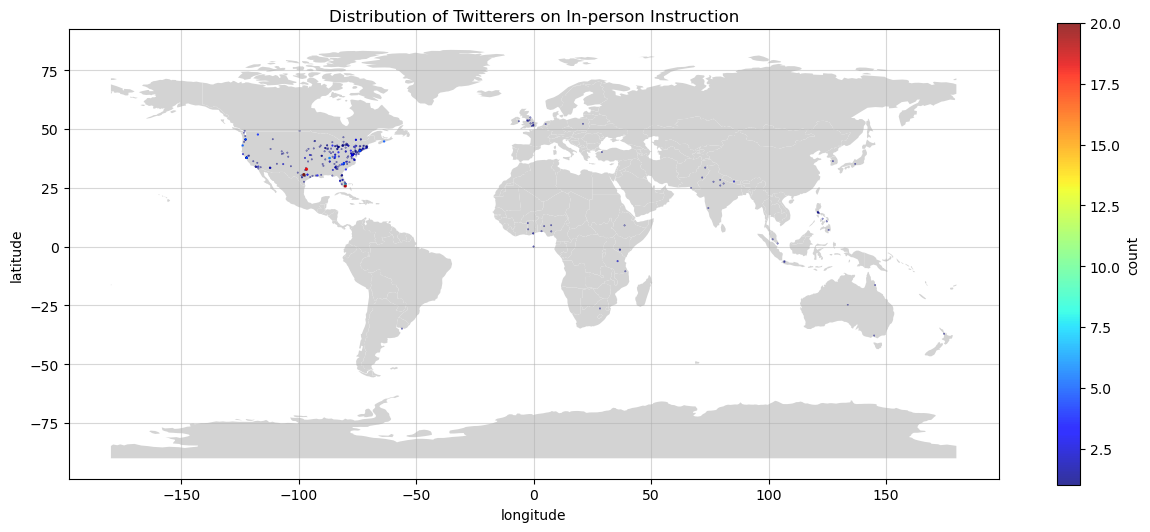

In [51]:
# initialize an axis
fig, ax = plt.subplots(figsize=(15,6))

# plot map on axis
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey",ax=ax)

# plot points
p_dist_tweet_ip.plot(x = "longitude", y = "latitude", kind = "scatter", s = p_dist_tweet_ip['count']/10,
                     c = "count", cmap = plt.get_cmap("jet"), alpha = 0.8,
                     title = "Distribution of Twitterers on In-person Instruction", ax = ax, colorbar = True)

# add grid
ax.grid(b = True, alpha = 0.5)
plt.show()

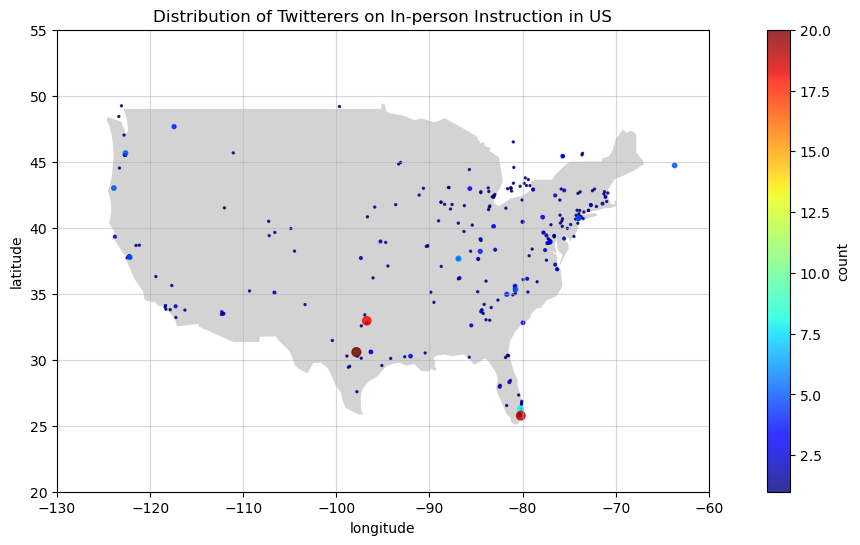

In [52]:
# initialize an axis
fig, ax = plt.subplots(figsize=(15,6))

# plot map on axis
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries[countries["name"] == "United States of America"].plot(color = "lightgrey", ax = ax)

# plot points
p_dist_tweet_ip.plot(x = "longitude", y = "latitude", kind = "scatter", s = p_dist_tweet_ip['count']*2,
                     c = "count", cmap = plt.get_cmap("jet"), alpha = 0.8,
                     title = "Distribution of Twitterers on In-person Instruction in US", ax = ax, colorbar = True)

# add grid
ax.grid(b = True, alpha = 0.5)
plt.xlim([-130, -60])
plt.ylim([20, 55])
plt.show()

# Timeline Analysis

In [34]:
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")
time_tweet = tweets_filtered.select('id', 'created_at').withColumn('created_at', date_format(to_timestamp("created_at", 'EEE MMM dd HH:mm:ss ZZZZ yyyy'), 'yyyy-MM-dd'))
time_tweet.limit(20).toPandas()

,id,created_at
0,1562002872362889216,2022-08-23
1,1562002876620148737,2022-08-23
2,1562002877219885056,2022-08-23
3,1562002877631156224,2022-08-23
4,1562002879476510721,2022-08-23
5,1562002880533565441,2022-08-23
6,1562002883754672128,2022-08-23
7,1562002885524656128,2022-08-23
8,1562002886258835457,2022-08-23
9,1562002888922222592,2022-08-23


In [35]:
timeline_tweet = time_tweet.groupby('created_at').count().orderBy('created_at')
timeline_tweet.limit(20).toPandas()

,created_at,count
0,2022-04-05,258207
1,2022-04-06,335615
2,2022-04-07,347104
3,2022-04-08,337943
4,2022-04-09,258686
5,2022-04-10,218924
6,2022-04-11,313472
7,2022-04-12,336797
8,2022-04-13,349708
9,2022-04-14,303469


In [36]:
p_timeline_tweet = timeline_tweet.toPandas()
p_timeline_tweet['created_at'] = pd.to_datetime(p_timeline_tweet['created_at']).dt.date

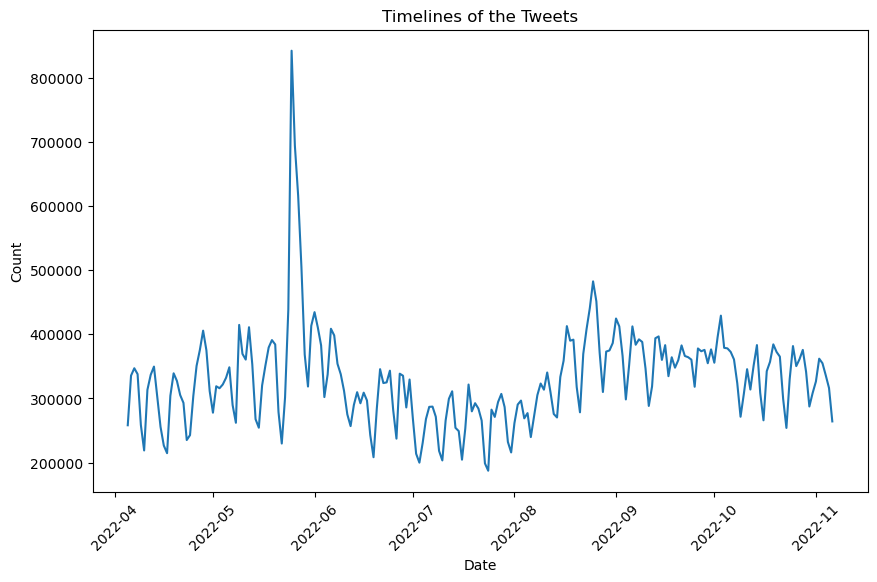

In [37]:
plt.figure(figsize = (10, 6))
sns.lineplot(x='created_at', y='count', data = p_timeline_tweet)
plt.xticks(rotation=45)
plt.locator_params(axis='both', nbins=8)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Timelines of the Tweets')
plt.show()

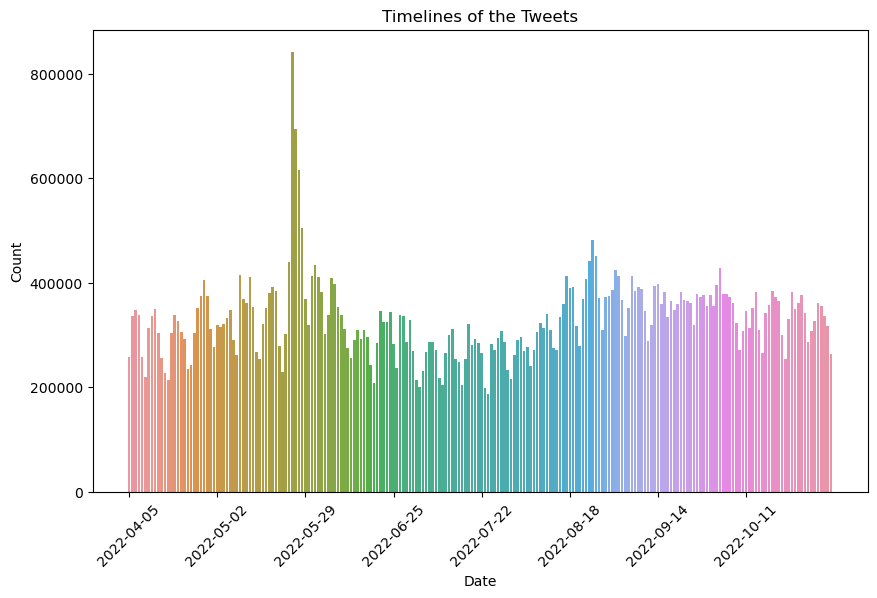

In [38]:
plt.figure(figsize = (10, 6))
sns.barplot(x='created_at', y='count', data = p_timeline_tweet)
plt.xticks(rotation=45)
plt.locator_params(axis='both', nbins=8)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Timelines of the Tweets')
plt.show()

# Save the Tweets Related to 'In-person Instruction' As Parquet Files

In [39]:
dir_out = 'inter_result/related'

In [40]:
#list_blobs_pd(bucket, dir_out)

,Name,Size


In [41]:
#delete_folder(bucket, dir_out)

In [42]:
#tweets_topic.write.format("parquet").\
#    mode('overwrite').\
#    save('gs://' + bucket + '/' + dir_out)

In [43]:
blob_list = list_blobs_pd(bucket, dir_out)
blob_list.head(10)

,Name,Size
0,inter_result/related/,0
1,inter_result/related/_SUCCESS,0
2,inter_result/related/part-00000-a01e717a-81ee-4634-bded-d7b1d005e3c3-c000.snappy.parquet,1317439
3,inter_result/related/part-00001-a01e717a-81ee-4634-bded-d7b1d005e3c3-c000.snappy.parquet,1262933
4,inter_result/related/part-00002-a01e717a-81ee-4634-bded-d7b1d005e3c3-c000.snappy.parquet,1627412
5,inter_result/related/part-00003-a01e717a-81ee-4634-bded-d7b1d005e3c3-c000.snappy.parquet,1429290
6,inter_result/related/part-00004-a01e717a-81ee-4634-bded-d7b1d005e3c3-c000.snappy.parquet,1230717
7,inter_result/related/part-00005-a01e717a-81ee-4634-bded-d7b1d005e3c3-c000.snappy.parquet,1420765
8,inter_result/related/part-00006-a01e717a-81ee-4634-bded-d7b1d005e3c3-c000.snappy.parquet,1442606
9,inter_result/related/part-00007-a01e717a-81ee-4634-bded-d7b1d005e3c3-c000.snappy.parquet,1331688
